Final Project for Text Information Systems (CS410 Fall 2022)
Video Game Review Classifier
Nate Smolczyk (nds6)

In [3]:
# The dataset includes all sorts of video game products, like memory cards and controllers. First I parse out the video game reviews and the attributes I need. 

import nltk
from nltk.corpus import stopwords
import pandas as pd
import json
import matplotlib.pyplot as plt


# Note: Raw data downloaded at https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Video_Games_5.json.gz
rawdata = open('Video_Games_5.json', 'r')
videogamedata = open('videogames.json', 'a')
Lines = rawdata.readlines()
last = Lines[-1]

videogamedata.write('[\n')
for line in Lines:
    x = json.loads(line)
    obj = {**x}
    if 'style' in obj:
        y = obj['style']
        if 'Format:' in y:
            format = y['Format:']
            if(format == ' Video Game' and 'reviewText' in obj):
                obj2 = {}
                obj2['rating'] = obj['overall']
                obj2['text'] = obj['reviewText'] 
                videogamedata.write(json.dumps(obj2) + ',\n')
    if line is last:
        videogamedata.write(']')



In [4]:
print(len(Lines))

497577


In [76]:
from sklearn.utils import shuffle
df = pd.read_json('./videogames.json')
df = shuffle(df)

<BarContainer object of 5 artists>

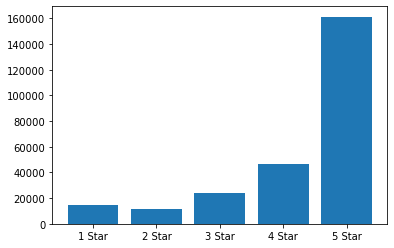

In [140]:
onestarratings = df[df['rating'] == 1]
twostarratings = df[df['rating'] == 2]
threestarratings = df[df['rating'] == 3]
fourstarratings = df[df['rating'] == 4]
fivestarratings = df[df['rating'] == 5]

yAxis = [onestarratings.size, twostarratings.size, threestarratings.size, fourstarratings.size, fivestarratings.size]
xAxis = ['1 Star', '2 Star', '3 Star', '4 Star', '5 Star']

plt.bar(xAxis, yAxis)


In [215]:
from sklearn.utils import shuffle
from nltk.tokenize import word_tokenize
subsetdata = pd.DataFrame()
subsetdata = subsetdata.append(onestarratings[0:12500])
#subsetdata = subsetdata.append(twostarratings[0:5000])
#subsetdata = subsetdata.append(threestarratings[0:5000])
#subsetdata = subsetdata.append(fourstarratings[0:5000])
subsetdata = subsetdata.append(fivestarratings[0:12500])
subsetdata = shuffle(subsetdata)



In [237]:
allWords = []
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string
wordCounts = {}
documents = []

def starToSentiment(rating):
    if(rating == 1 or rating == 2):
        return "negative"
    if(rating == 3):
        return "neutral"
    if(rating == 4 or rating == 5):
        return "positive"

stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

def getTokens(document):
    tokens = word_tokenize(document)
    tokens = [t for t in tokens if t.isalpha() ]
    tokens = [t.lower() for t in tokens ]
    tokens = [t for t in tokens if not t in stop_words]
    tokens = [t for t in tokens if len(t) > 2 and len(t) < 30]
    tokens = [ps.stem(t) for t in tokens ]
    return tokens



for index, row in subsetdata.iterrows():
    text = row['text']
    tokens = getTokens(text)
    for token in tokens:
        allWords.append(token)
    documents.append((tokens, starToSentiment(row["rating"])))
    

In [238]:
from collections import Counter
word_count = Counter(allWords)
word_count.most_common(20)

[('game', 55369),
 ('play', 16694),
 ('like', 11289),
 ('get', 9861),
 ('one', 9747),
 ('time', 8074),
 ('great', 6492),
 ('good', 6012),
 ('even', 5513),
 ('make', 5329),
 ('realli', 5310),
 ('fun', 5180),
 ('would', 4799),
 ('first', 4724),
 ('much', 4636),
 ('stori', 4577),
 ('graphic', 4526),
 ('charact', 4425),
 ('love', 4262),
 ('use', 4230)]

In [239]:

all_words = nltk.FreqDist(w for w in allWords)

word_features = list(all_words)[:5000]

def retrieveReviewLengthFeature(count):
    if count <= 10:
        return "LessThan10"
    elif count > 10 and count < 100:
        return "between10and100"
    elif count >= 100 and count < 200:
        return "between100and200"
    elif count >= 200 and count < 300:
        return "between200and300"
    elif count >= 300 and count < 400:
        return "between300and400"
    elif count >= 400 and count < 500:
        return "betwee400and500"
    elif count >= 500:
        return "greaterThan500"
    

def getFeatures(bagOfWords):
    uniqueWords = set(bagOfWords)
    features = {}
    for word in word_features:
        features[word] = (word in uniqueWords)
    features['reviewLength'] = retrieveReviewLengthFeature(len(bagOfWords))
    return features

In [240]:
print(len(documents))

19664


In [241]:
# Train Naive Bayes classifier
featuresets = [(getFeatures(bagOfWords), rating) for (bagOfWords,rating) in documents]
print(len(featuresets))
train_set, test_set = featuresets[0:15000], featuresets[15000:20000]
classifier = nltk.NaiveBayesClassifier.train(train_set)

19664


In [242]:
# Test the classifier
print(nltk.classify.accuracy(classifier, test_set))

0.7521440823327615


In [254]:
def classifyText(text):
    tokens = getTokens(text)
    return classifier.classify(getFeatures(tokens))

print(classifyText("garbage garbage garbage garbage garbage garbage garbage garbage garbage garbage garbage garbage garbage garbage garbage garbage garbage garbage garbage"))

positive


In [256]:
classifier.show_most_informative_features(10)

Most Informative Features
                 securom = True           negati : positi =     49.2 : 1.0
                  pathet = True           negati : positi =     47.8 : 1.0
                unaccept = True           negati : positi =     45.5 : 1.0
                  refund = True           negati : positi =     44.3 : 1.0
               unrespons = True           negati : positi =     43.1 : 1.0
                    scam = True           negati : positi =     40.7 : 1.0
                  horrid = True           negati : positi =     31.5 : 1.0
                 disgrac = True           negati : positi =     31.3 : 1.0
                unfinish = True           negati : positi =     30.8 : 1.0
                reinstal = True           negati : positi =     30.1 : 1.0


In [ ]:
from nltk.classify.util import names_demo

classifier = names_demo(nltk.NaiveBayesClassifier.train)
classifier.show_most_informative_features()

In [203]:
vals = [1,2,3,4,5]

for val in vals:
    val = "hi"

print(vals)

[1, 2, 3, 4, 5]
